# Обучение полносвязной нейронной сети

Сначала подготовим данные

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns           
import sklearn   

In [2]:
# from google.colab import files 
# files.upload()

In [3]:
# !pip install -q kaggle

In [4]:
# !mkdir -p ~/.kaggle 
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [5]:
# !kaggle datasets download -d murderaccountability/homicide-reports

In [6]:
# !ls

In [7]:
# !unzip homicide-reports.zip

In [8]:
data = pd.read_csv("database.csv", low_memory = False, sep = ',')

In [9]:
data.shape

(638454, 24)

Немного обрежем и уберём ненужные столбцы

In [10]:
rows_to_drop = data[(data['Record ID'] > 200000)].index

In [11]:
data = data.drop(rows_to_drop)
data.shape

(200000, 24)

In [12]:
del data['Record ID']
del data['Agency Code']
del data['Agency Name']
del data['State']
del data['Year']

In [13]:
data.shape

(200000, 19)

Признак **Crime Solved** - бинарный, признаки **Incident, Victim Age, Perpetdator Age, Victim Count,  Perpetdator Count** - числовые, остальные - номинальные (категориальные).

Нужно предсказать признак **Crime Solved** по остальным признакам - это задача классификации.

In [14]:
data['Perpetrator Age'] = pd.to_numeric(data['Perpetrator Age'], errors='coerce')

Заполнение пропущенных значений

In [16]:
data['Victim Age'] = data['Victim Age'].replace(0, data['Victim Age'].median()) 
data['Perpetrator Age'] = data['Perpetrator Age'].replace(0, data['Perpetrator Age'].median()) 

Обработаем категориальные признаки

In [17]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['Agency Type', 'City', 'Month', 'Crime Type', 'Crime Solved', 'Victim Sex', 'Victim Race', 'Victim Ethnicity', 'Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Ethnicity', 'Relationship', 'Weapon', 'Record Source']
['Incident', 'Victim Age', 'Perpetrator Age', 'Victim Count', 'Perpetrator Count']


In [18]:
data_describe = data.describe(include = [object])
for c in categorical_columns:
    data[c] = data[c].fillna(data_describe[c]['top'])

Бинарные:

In [19]:
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

['Crime Type', 'Crime Solved'] ['Agency Type', 'City', 'Month', 'Victim Sex', 'Victim Race', 'Victim Ethnicity', 'Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Ethnicity', 'Relationship', 'Weapon']


In [20]:
data['Crime Type'] = pd.factorize(data['Crime Type'])[0]
data['Crime Solved'] = pd.factorize(data['Crime Solved'])[0]
data['Record Source'] = pd.factorize(data['Record Source'])[0]

Небинарные:

In [22]:
data_nonbinary = pd.get_dummies(data[nonbinary_columns])
print(data_nonbinary.columns)

Index(['Agency Type_County Police', 'Agency Type_Municipal Police',
       'Agency Type_Regional Police', 'Agency Type_Sheriff',
       'Agency Type_Special Police', 'Agency Type_State Police',
       'Agency Type_Tribal Police', 'City_Abbeville', 'City_Acadia',
       'City_Accomack',
       ...
       'Weapon_Firearm', 'Weapon_Gun', 'Weapon_Handgun', 'Weapon_Knife',
       'Weapon_Poison', 'Weapon_Rifle', 'Weapon_Shotgun',
       'Weapon_Strangulation', 'Weapon_Suffocation', 'Weapon_Unknown'],
      dtype='object', length=1758)


Нормализация признаков

In [24]:
data_numerical = data[numerical_columns]

In [25]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)

In [26]:
data = pd.concat((data_numerical, data_nonbinary, data[binary_columns]), axis = 1)
print(data.shape)

(200000, 1765)


In [27]:
# data.to_csv('normdata.csv', sep = ',')

Отбор признаков

In [28]:
X = data.drop('Crime Solved', axis = 1) 
y = data['Crime Solved']
feature_names = X.columns

In [29]:
# X.to_csv('X.csv', sep = ',')
# y.to_csv('y.csv', sep = ',')

Разбиваем данные на обучающую и тестовую выборки

In [30]:
# X = pd.read_csv("X.csv", low_memory = False, sep = ',')

In [31]:
# y = pd.read_csv("y.csv", low_memory = False, sep = ',')

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 7)
N_test, _ = X_test.shape

# Обучаем классификатор

In [34]:
from sklearn.neural_network import MLPClassifier

In [35]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          random_state = 42)

In [36]:
%%time
mlp_model.fit(X_train, y_train)

Wall time: 20.2 s


MLPClassifier(activation='logistic', random_state=42, solver='lbfgs')

Проверим качество

In [44]:
from sklearn.metrics import accuracy_score

In [43]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [45]:
accuracy_score(y_train, y_train_pred)

0.9999850746268657

In [46]:
accuracy_score(y_test, y_test_pred)

0.9999393939393939

Подбор гиперпараметров.
Подберем оптимальное значение параметра регуляризации ```alpha```

In [47]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=1000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

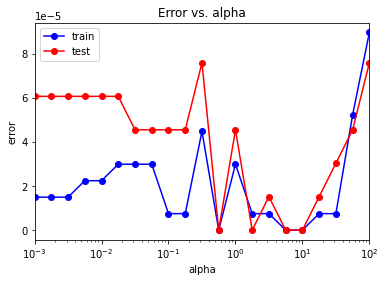

In [48]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

При ```alpha``` < 0.5 происходит переобучение.

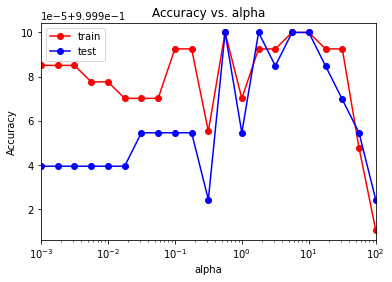

In [49]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

Минимальное значение ошибки:

In [50]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.0 0.0


Оптимальное значение ```alpha```:

In [52]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[ 0.56234133  1.77827941  5.62341325 10.        ]


Подберём оптимальное количество нейронов при ```alpha```=0.56234133

In [68]:
num_neurons_arr = (np.linspace(1, 300, 80)).astype(int)
test_err = []
train_err = []

for neuron in num_neurons_arr:
    mlp_model = MLPClassifier(alpha = 0.56234133, hidden_layer_sizes = (neuron,), 
                              solver = 'lbfgs', 
                              activation = 'logistic', 
                              max_iter=1000, 
                              random_state = 40)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

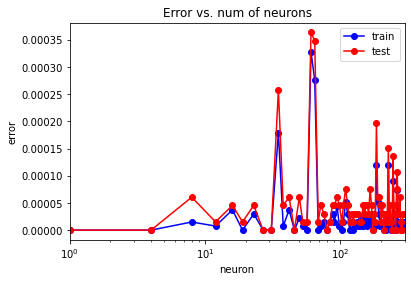

In [75]:
plt.semilogx(num_neurons_arr, train_err, 'b-o', label = 'train')
plt.semilogx(num_neurons_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(num_neurons_arr), np.max(num_neurons_arr)])
plt.title('Error vs. num of neurons')
plt.xlabel('neuron')
plt.ylabel('error')
plt.legend()

In [76]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print('Минимальное значение ошибки:',min_train_err, min_test_err)

Минимальное значение ошибки: 0.0 0.0


In [77]:
num_neurons_opt = neuron_arr[test_err == min_test_err][0]
print('Оптимальное количество нейронов:',num_neurons_opt)

Оптимальное количество нейронов: 1


Классификатор с оптимальным ```alpha```=0.56234133 и  1 нейроном:

In [78]:
mlp_model = MLPClassifier(alpha = 0.56234133, hidden_layer_sizes = (num_neurons_opt,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 40)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print('Итоговая точность:')
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

Итоговая точность:
1.0
1.0


Матрица рассогласования:

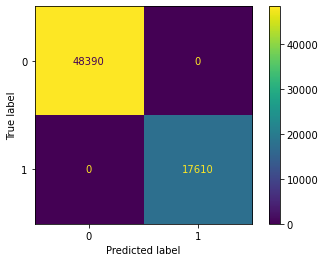

In [73]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(mlp_model, X_test, y_test) 

In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48390
           1       1.00      1.00      1.00     17610

    accuracy                           1.00     66000
   macro avg       1.00      1.00      1.00     66000
weighted avg       1.00      1.00      1.00     66000



# Вывод
Оптимальное количество нейронов 1. Оптимальное значение параметра ```alpha```=0.56234133, при меньших значениях происходит переобучение. Итоговая точность 100%, немного точнее, чем метод k-ближайших соседей с 2 соседями.